In [35]:
import requests
import time
import re
import pandas as pd
from collections import Counter
from nltk import tokenize

In [36]:
EAP_start = 1827
EAP_end = 1849
EAP_major_works = [1831, 1839, 1843, 1845, 1846, 1849]
HPL_start = 1910
HPL_end = 1943
HPL_major_works = [1928, 1936, 1943]
MWS_start = 1818
MWS_end = 1837
MWS_major_works = [1818, 1823, 1826, 1830, 1835, 1837]

In [37]:
import nltk
from nltk.corpus import stopwords

In [39]:
df = pd.read_csv('train.csv', index_col='id')


In [126]:
df2 = pd.read_csv('train.csv', index_col='id')

In [40]:
ngram_data_regex = re.compile(r'imeseries\": \[(\d|\.|\s|,|e|-)*\]')

In [41]:
def get_ngram_frequency_from_request(request, regex):
    results = []
    frequencies = regex.search(request.text).group()
    frequencies = frequencies[13:-1]
    frequencies = frequencies.split(", ")
    frequencies = [float(f) for f in frequencies]
    results.append(np.mean([f for f in frequencies[EAP_start-1818:EAP_end-1818] if f>0]))
    results.append(np.mean([f for f in frequencies[HPL_start-1818:HPL_end-1818] if f>0]))
    results.append(np.mean([f for f in frequencies[MWS_start-1818:MWS_end-1818] if f>0]))
    return results

In [42]:
token_list = []
stopWords = set(stopwords.words('english'))
for sentence in df.text:
    tokens = tokenize.word_tokenize(sentence)
    tokens = [t for t in tokens if len(t)>1 and t not in stopWords]
    token_list.append(tokens)

In [43]:
lexicon = set()
for sentence in token_list:
    lexicon.update(sentence)

In [44]:
len(lexicon)

27575

In [45]:
lexicons = []
for author in ['EAP', 'HPL', 'MWS']:
    author_lexicon = set()
    for sentence in df[df['author']==author].text:
        tokens = tokenize.word_tokenize(sentence)
        tokens = [t.lower() for t in tokens if len(t)>1 and t not in stopWords]
        author_lexicon.update(tokens)
    lexicons.append(author_lexicon)

In [46]:
EAP_lexicon, HPL_lexicon, MWS_lexicon = lexicons

In [47]:
print(len(EAP_lexicon), len(HPL_lexicon), len(MWS_lexicon))

15443 14495 11536


In [48]:
MWS_unique_words = MWS_lexicon.difference(HPL_lexicon.union(EAP_lexicon))
len(MWS_unique_words)

3003

In [49]:
HPL_unique_words = HPL_lexicon.difference(MWS_lexicon.union(EAP_lexicon))
len(HPL_unique_words)

5584

In [50]:
EAP_unique_words = EAP_lexicon.difference(HPL_lexicon.union(MWS_lexicon))
len(EAP_unique_words)

5882

In [114]:
# POP method is destructive - removes and returns the items from the set. Re-run above three cells after experimentation
for i in range(20):
    word = EAP_unique_words.pop()
    print(word, wordcounts[word], sum([word in text for text in df.text]))

fastening 1 6
eave 1 344
bug 29 26
'wery 1 0
strived 1 1
fairies 2 1
doux 2 2
saucer 1 2
perseveringly 2 2
editors 2 8
predicate 1 1
esquimau 1 0
cimabué 1 0
chateaubriand 1 0
stables 6 7
sacks 1 1
morto 1 2
riper 1 1
assumes 2 2
waker 9 9


In [52]:
def get_lexicon_frequencies(lexicon):
    lexicon_frequencies = []
    error_counter = 0
    sleep_time = 1
    BASEURL = "https://books.google.com/ngrams/graph?content={}&year_start=1818&year_end=1943&corpus=16&smoothing=0"
    for n, word in enumerate(lexicon):
        if n%1378 == 1:
            print("{}% done!".format(round(len(lexicon)/n), 2))
        if error_counter > 8:
            print("too many errors. Sleep time = {}".format(sleep_time))
            break
        request = requests.get(BASEURL.format(word))
        if request.status_code != 200:
            error_counter += 1
            time.sleep(sleep_time)
            request = requests.get(BASEURL.format(word))
            if request.status_code != 200:
                error_counter += 1
                print("two consecutive errors")
                print(request.status_code, request.text)
                time.sleep(300)
                sleep_time *= 2
        ngram_frequencies = get_ngram_frequency_from_request(request, ngram_data_regex)
        lexicon_frequencies.append((word, ngram_frequencies))
        time.sleep(sleep_time)
    return lexicon_frequencies

NameError: name 'lexicon_frequencies' is not defined

In [ ]:
import string
from nltk.corpus import stopwords
string.punctuation

In [60]:
min(min(EAP_major_works), min(MWS_major_works), min(HPL_major_works))

1818

In [68]:
max(max(EAP_major_works), max(MWS_major_works), max(HPL_major_works))

1943

In [69]:
authors = ['EAP', 'HPL', 'MWS']

In [70]:
for author in authors:
    print("Average length of sentences by {}: {}".format(author, np.mean([len(t) for t in df[df['author']==author].text])))

Average length of sentences by EAP: 142.22594936708862
Average length of sentences by HPL: 155.84347826086957
Average length of sentences by MWS: 151.65982792852415


In [71]:
for author in authors:
    print("Number of strings by {}: {}".format(author, df[df['author']==author].shape[0]))
    print("Number of words by {}: {}".format(author, sum([len(t.split(" ")) for t in df[df['author']==author].text])))
    print("Average words per string: {}".format((sum([len(t.split(" ")) for t in df[df['author']==author].text]))/df[df['author']==author].shape[0]))

Number of strings by EAP: 7900
Number of words by EAP: 200995
Average words per string: 25.44240506329114
Number of strings by HPL: 5635
Number of words by HPL: 156651
Average words per string: 27.799645075421473
Number of strings by MWS: 6044
Number of words by MWS: 165710
Average words per string: 27.417273328921244


In [72]:
EAP_strings, MWS_strings, HPL_strings = 7900, 6044, 5635
EAP_words, MWS_words, HPL_words = 200995, 165710, 156651

In [73]:
string_ratios = np.asarray([EAP_strings, HPL_strings, MWS_strings])/(EAP_strings + HPL_strings + MWS_strings)

In [74]:
string_ratios

array([0.40349354, 0.28780837, 0.30869809])

In [75]:
word_ratios = np.asarray([EAP_words, HPL_words, MWS_words])/(EAP_words + HPL_words + MWS_words)

In [76]:
word_ratios

array([0.38405024, 0.29932016, 0.3166296 ])

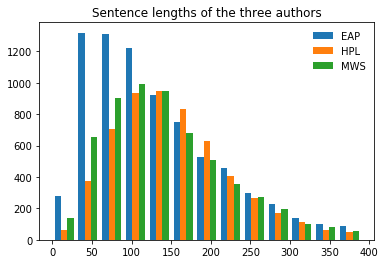

In [161]:
import matplotlib.pyplot as plt

EAP_sentence_lengths = [len(t) for t in df[df['author']=='EAP'].text]
HPL_sentence_lengths = [len(t) for t in df[df['author']=='HPL'].text]
MWS_sentence_lengths = [len(t) for t in df[df['author']=='MWS'].text]
labels = ['EAP', 'HPL', 'MWS']

plt.figure()
H = plt.hist([EAP_sentence_lengths, HPL_sentence_lengths, MWS_sentence_lengths], label=labels, bins=[i for i in range(0, 400, 30)])
leg = plt.legend(frameon=False)
plt.title("Sentence lengths of the three authors")
plt.show()

In [78]:
plt.figure()
H = plt.hist([EAP_word_counts, HPL_word_counts, MWS_word_counts], label=labels, bins=[i for i in range(0, 60, 3)])
leg = plt.legend(frameon=False)
plt.title("Words per sentence of the three authors")
plt.show()

NameError: name 'EAP_word_counts' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
for author in authors:
    uppers = 0
    total = 0
    for t in df[df['author']==author].text:
        total += len(t)
        uppers += sum([l.isupper() for l in t])
    print("Number of capital letters by {}: {}\tRatio: {}"
          .format(author, uppers, uppers/total))

In [ ]:
for author in authors:
    print("Average characters per word by {}: {}"
          .format(author, (sum([len(t) for t in df[df['author']==author].text])/
                           (sum([len(t.split(" ")) for t in df[df['author']==author].text])))))

In [133]:
for author in authors:
    print("Number of strings containing the word 'l\'' by {}: {}".format(author, sum([':' in t for t in df2[df2['author']==author].text])))

Number of strings containing the word 'l'' by EAP: 165
Number of strings containing the word 'l'' by HPL: 46
Number of strings containing the word 'l'' by MWS: 306


In [147]:
chars = re.compile(r'[à|â|æ|ç|è|ë|ê|ï|î|ô|œ|ÿ|û|ù|á|é|í|ó|ú|ü]')
chars.findall("flimflám")

['á']

In [171]:
for author in authors:
    print("Number of strings containing accented characters by {}: {}".format(author, sum([1 for c in [chars.search(t.lower()) for t in df[df['author']==author].text] if c])))

Number of strings containing accented characters by EAP: 116
Number of strings containing accented characters by HPL: 52
Number of strings containing accented characters by MWS: 0


In [158]:
sum([1 for c in [chars.findall(t) for t in df2[df2['author']=='EAP'].text] if c])

116

In [80]:
for author in authors:
    print("Number of strings containing the word 'whence' by {}: {}".format(author, sum(['whence' in t.lower() for t in df[df['author']==author].text])))

Number of strings containing the word 'whence' by EAP: 9
Number of strings containing the word 'whence' by HPL: 10
Number of strings containing the word 'whence' by MWS: 8


In [174]:
for author in authors:
    print("Number of strings containing ! by {}: {}".format(author, sum(['\!' in t for t in df[df['author']==author].text])))

Number of strings containing ! by EAP: 0
Number of strings containing ! by HPL: 0
Number of strings containing ! by MWS: 0


In [173]:
for author in authors:
    print("Number of strings containing L' or l' by {}: {}".format(author, sum(['l\''  in t.lower() for t in df[df['author']==author].text])))

Number of strings containing L' or l' by EAP: 83
Number of strings containing L' or l' by HPL: 22
Number of strings containing L' or l' by MWS: 19


In [172]:
for author in authors:
    print("Number of strings containing a semicolon by {}: {}".format(author, sum([';'  in t.lower() for t in df[df['author']==author].text])))

Number of strings containing a semicolon by EAP: 1084
Number of strings containing a semicolon by HPL: 1084
Number of strings containing a semicolon by MWS: 1969


In [82]:
for author in authors:
    print("Number of strings containing quotation marks by {}: {}".format(author, sum(['\"' in t for t in df[df['author']==author].text])))

Number of strings containing quotation marks by EAP: 1326
Number of strings containing quotation marks by HPL: 313
Number of strings containing quotation marks by MWS: 788


In [83]:
for author in authors:
    print("Number of strings containing 'ae' by {}: {}".format(author, sum(['ae' in t for t in df[df['author']==author].text])))

Number of strings containing 'ae' by EAP: 67
Number of strings containing 'ae' by HPL: 118
Number of strings containing 'ae' by MWS: 33


In [167]:
for author in authors:
    print("Number of strings containing 'æ' by {}: {}".format(author, sum(['æ' in word for word in [t for t in df[df['author']==author].text]])))

Number of strings containing 'æ' by EAP: 32
Number of strings containing 'æ' by HPL: 9
Number of strings containing 'æ' by MWS: 0


In [168]:
df[df['author']==author].text[0]

'How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.'

In [84]:
from nltk import tokenize

In [85]:
tokenize.word_tokenize(df.text[0])[:10]

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of']

In [86]:
n = 0
len(lexicon)

27575

In [87]:
len(lexicon)/75

367.6666666666667

In [88]:
from collections import Counter

In [162]:
wordcounts = Counter()
for sentence in token_list:
    wordcounts.update([t.lower() for t in sentence])
wordcounts.most_common(10)

[('``', 2762),
 ('the', 2225),
 ("''", 2207),
 ('one', 1623),
 ('upon', 1411),
 ("'s", 1355),
 ('could', 1330),
 ('would', 1258),
 ('it', 947),
 ('he', 900)]

In [90]:
wordlist = []
for word, count in wordcounts.items():
    if 5 < count < 200:
        wordlist.append(word)
len(wordlist)

7227

In [91]:
for word in wordlist[90:100]:
    print("{}: {}".format(word, wordcounts[word]))

blanc: 11
breadth: 14
beginning: 45
peer: 12
grin: 9
artists: 8
wondrous: 15
imitation: 13
merest: 6
thousands: 16


In [92]:
bleh = 0
for text in df.text:
    if not text[0].isupper():
        print(text)
        bleh += 1
    if bleh > 10:
        break

"The present peculiar condition of affairs at court, and especially of those intrigues in which D is known to be involved, would render the instant availability of the document its susceptibility of being produced at a moment's notice a point of nearly equal importance with its possession."
"And what about the window panes?" "They were all gone.
"But could not the cavity be detected by sounding?"
"Everybody got aout o' the idee o' dyin' excep' in canoe wars with the other islanders, or as sacrifices to the sea gods daown below, or from snake bite or plague or sharp gallopin' ailments or somethin' afore they cud take to the water but simply looked forrad to a kind o' change that wa'n't a bit horrible arter a while.
"That is absolutely needless," replied G .
"Keep up the largest branch the one on this side," said Legrand.
"But, my dear fellow, you are joking then," said I, "this is a very passable skull indeed, I may say that it is a very excellent skull, according to the vulgar notions 

In [93]:
this = Counter()
for n, text in enumerate(df.text):
    if not text[0].isupper():
        this[df.iloc[n].author] += 1
print(this)

Counter({'EAP': 793, 'MWS': 381, 'HPL': 167})


In [94]:
def load_word_frequencies(filename):
    data = []
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            w, e, h, m = line.replace("\"", "").replace("[","").replace("]","").replace(" ","").split(",")[1:]
            data.append([w, float(e), float(h), float(m)])
    return data
            

In [95]:
line.replace("\"", "").replace("[","").replace("]","").replace(" ","").split(",")[1:]

NameError: name 'line' is not defined

In [96]:
line = "3,afforded,\"[4.5339866284683176e-05, 1.017405086465508e-05, 4.7641757670422327e-05]\""

In [97]:
columns = ['word', 'EAP_frequency', 'HPL_frequency', 'MWS_frequency']
data = load_word_frequencies('lexicon_frequencies.csv')
df_word_frequency = pd.DataFrame(data, columns=columns)

In [98]:
df_word_frequency

,word,EAP_frequency,HPL_frequency,MWS_frequency
0,This,0.000640,0.000519,0.000715
1,process,0.000024,0.000026,0.000025
2,however,0.000477,0.000213,0.000470
3,afforded,0.000045,0.000010,0.000048
4,means,0.000270,0.000151,0.000275
5,ascertaining,0.000005,0.000001,0.000005
6,dimensions,0.000011,0.000004,0.000015
7,dungeon,0.000011,0.000004,0.000012
8,might,0.000818,0.000706,0.000810
9,make,0.000600,0.000663,0.000592


In [99]:
this = pd.read_csv('lexicon_frequencies.csv')
this.shape

(22, 3)

In [100]:
random = df.iloc[4898]

In [101]:
def get_sentence_probability(sentence):
    a, b, c = 0, 0, 0
    for word in tokenize.word_tokenize(sentence):
        if word.lower() in list(df_word_frequency.word):
            log_probs = [math.log(v) for v in df_word_frequency.loc[word.lower()][1:]]
            a += log_probs[0]
            b += log_probs[1]
            c += log_probs[2] 
    return (a, b, c)

In [102]:
df_word_frequency.index = df_word_frequency.word

In [103]:
probs = [v for v in df_word_frequency.loc['process']][1:]

In [104]:
[probs[i]/sum(probs) for i in range(3)]

[0.317976641313019, 0.34895560935665504, 0.33306774933032596]

In [105]:
counter = 0
for i in range(df.shape[0]):
    line = df.iloc[i]
    p = get_sentence_probability(line.text)
    if (np.argmax(p) == 0 and line.author == 'EAP') or (np.argmax(p) == 1 and line.author == 'HPL') or (np.argmax(p) == 2 and line.author == 'MWS'):
        counter += 1
print(counter, df.shape[0])


7703 19579


In [106]:
import math 

In [107]:
def predict(sentence):
    probs = get_sentence_probability(sentence)
    print(probs, np.argmin(probs), authors[np.argmin(probs)])
    return authors[np.argmin(probs)]

In [108]:
def predict_with_probs(sentence):
    probs = get_sentence_probability(sentence)
    if sum(probs) == 0:
        return None
    probs = [probs[i]/sum(probs) for i in range(3)]
    return (authors[np.argmin(probs)], probs)

In [109]:
def s(i):
    r = df.iloc[i]
    print(predict_with_probs(r.text), r.author)